# Effective_Precipitation_Consumptive_Use

Notebook to compile various Castle Valley datasets into one for comparison.  Uses WRLU-spatial data. 
Source notebooks include:
* [SWB postprocess v2](http://localhost:59983/lab/tree/Projects_and_Proposals/Castledale_ET/Jupyter_Notebooks/SWB%20Postprocess%20v2.ipynb)
* [Zonal_Stats_on_Openet_Rasters](http://localhost:59983/lab/tree/Projects_and_Proposals/Castledale_ET/Jupyter_Notebooks/Zonal_Stats_on_Openet_Rasters.ipynb)
* [Cottonwood_Daily_Data_Scrape](http://localhost:59983/lab/tree/Projects_and_Proposals/Castledale_ET/Jupyter_Notebooks/Cottonwood_Daily_Data_Scrape.ipynb)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import urllib

import rioxarray # for the extension to load
import xarray
import rasterio
import geopandas as gpd
#import xrspatial as xrs
from rasterstats import zonal_stats
import rasterstats
import platform
import requests
import sys
import datetime
import os

import argparse
import re
from typing import Sequence

import dask
import pandas as pd
import rioxarray  # noqa: F401  (side‑effect: registers .rio accessor)
import xarray as xr
from tqdm import tqdm

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

import pathlib

import pyproj
from pyproj import Proj
#import simplekml

import netCDF4
import warnings
warnings.simplefilter("ignore") 
#from geocube.api.core import make_geocube

In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])
print(datetime.datetime.today())

Operating System Windows 11
Python Version 3.13.1 | packaged by conda-forge | (main, Jan 13 2025, 09:37:28) [MSC v.1942 64 bit (AMD64)]
Pandas Version 2.2.3
Numpy Version 2.2.2
Matplotlib Version 3.10.0
py313
2025-07-30 19:04:26.299365


# Import Files

In [3]:
#main_path = pathlib.Path("G:/Shared Drives/UGS_Groundwater/Projects/Pahvant_Valley/")
main_path = pathlib.Path(r"G:\Shared Drives\UGS_Flux\Projects_and_Proposals\Castledale_ET")#watersheds_w_valley.shp
#figure_dir = main_path / "Writing" / "Figures" / "GEE_out"
#raw_dir = main_path / "Pahvant_Basins"
#save_place = raw_dir / "GEE_out"
#
#swb_main_path = pathlib.Path(r"C:\Users\paulinkenbrandt\Documents\ArcGIS\Projects\UFN")
#swb_coarse_path = swb_main_path / "swb_coarse" / "cottonwood_SWB_100m_v2" / "output_netcdfs"
#swb_fine_path = swb_main_path / "SWB" / "output_netcdfs"

ctnpath = main_path / "ctnpath"
gpmpath = ctnpath / "ewcd_api_download"
manpath = ctnpath / "manually_downloaded_meters"

In [4]:
gis_path = main_path / "GIS"
zones_wrlu = gpd.read_file(gis_path / 'zonal_table.geojson')#"C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/WRLU_for_ET_Est.shp")
zones_wrlu['ID'] = zones_wrlu.index
zones_wrlu_wgs = zones_wrlu.to_crs('epsg:4326')
zones_wrlu_wgs['Acres'] =zones_wrlu.to_crs('epsg:5070').geometry.area*0.000247105

match_dict_meternu = zones_wrlu_wgs.set_index(['zonal_id'])['Meternumbe']
match_dict_acres = zones_wrlu_wgs.set_index(['zonal_id'])['Acres']

In [5]:
eff_ppt_percent = 0.9

# Import OpenET data and Calc Eff Precip

In [19]:
wrlu = pd.read_parquet("wrlu_daily_eemetric.parquet")

df = pd.read_csv(main_path / "WRLU_dly_Zonal_Water_Volume_AcreFt_2016-01-01_2025-05-01.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
gee_ppt = df.set_index(['zonal_id','datetime','band']).drop(columns=['system:index','.geo'])['acre_ft'].unstack(level=-1)

wrlu_eemetric = wrlu.stack().to_frame().rename(columns={0:"eeMetricET"})
wrlu_eemetric['eeMetricET'] = wrlu_eemetric['eeMetricET'] * 0.0393701
wrlu_eemetric.index.names = ['datetime','zonal_id']
wrlu_eemetric = wrlu_eemetric.reset_index().set_index(['zonal_id','datetime']).sort_index()
wrlu_data = pd.merge(gee_ppt, wrlu_eemetric, left_index=True, right_index=True)

wrlu_data['eff_pr_gridmet'] = wrlu_data['pr'] * eff_ppt_percent
wrlu_data['eff_pr_daymet'] = wrlu_data['prcp'] * eff_ppt_percent

wrlu_data['net_et_gridmet'] = wrlu_data['eeMetricET'] - wrlu_data['eff_pr_gridmet']
wrlu_data['net_et_daymet'] = wrlu_data['eeMetricET'] - wrlu_data['eff_pr_daymet']

wrlu_data['Meterno'] = wrlu_data.index.get_level_values(0).map(match_dict_meternu)
wrlu_data['Acres'] = wrlu_data.index.get_level_values(0).map(match_dict_acres)
wrlu_by_meter = wrlu_data.reset_index().groupby(['Meterno','datetime']).sum()

In [29]:
wrlu_data

eto       etr  ppt   pr  prcp  swe  eeMetricET  \
zonal_id datetime                                                          
0.0      2023-05-01  1.104662  1.610966  0.0  0.0   0.0  0.0    0.780680   
         2023-05-02  0.966580  1.411513  0.0  0.0   0.0  0.0    0.681720   
         2023-05-03  0.981922  1.396171  0.0  0.0   0.0  0.0    0.692716   
         2023-05-04  0.859182  1.258088  0.0  0.0   0.0  0.0    0.604752   
         2023-05-05  0.644386  0.905210  0.0  0.0   0.0  0.0    0.450815   
...                       ...       ...  ...  ...   ...  ...         ...   
235.0    2023-12-27       NaN       NaN  NaN  NaN   0.0  0.0    0.001036   
         2023-12-28       NaN       NaN  NaN  NaN   0.0  0.0    0.001036   
         2023-12-29       NaN       NaN  NaN  NaN   0.0  0.0    0.001727   
         2023-12-30       NaN       NaN  NaN  NaN   0.0  0.0    0.001727   
         2023-12-31       NaN       NaN  NaN  NaN   0.0  0.0    0.001422   

                     eff_pr_gridmet  eff_pr_daymet  net_et_gridmet  \
zonal_id datetime                                                    
0.0      2023-05-01             0.0            0.0        0.780680   
         2023-05-02             0.0            0.0        0.681720   
         2023-05-03             0.0            0.0        0.692716   
         2023-05-04             0.0            0.0        0.604752   
         2023-05-05             0.0            0.0        0.450815   
...                             ...            ...             ...   
235.0    2023-12-27             NaN            0.0             NaN   
         2023-12-28             NaN            0.0             NaN   
         2023-12-29             NaN            0.0             NaN   
         2023-12-30             NaN            0.0             NaN   
         2023-12-31             NaN            0.0             NaN   

                     net_et_daymet Meterno      Acres  
zonal_id datetime                                      
0.0      2023-05-01       0.780680    CW40  46.805097  
         2023-05-02       0.681720    CW40  46.805097  
         2023-05-03       0.692716    CW40  46.805097  
         2023-05-04       0.604752    CW40  46.805097  
         2023-05-05       0.450815    CW40  46.805097  
...                            ...     ...        ...  
235.0    2023-12-27       0.001036    CW21   2.742238  
         2023-12-28       0.001036    CW21   2.742238  
         2023-12-29       0.001727    CW21   2.742238  
         2023-12-30       0.001727    CW21   2.742238  
         2023-12-31       0.001422    CW21   2.742238  

[88718 rows x 13 columns]

In [20]:
openetdir = main_path / "Jupyter_Notebooks" / "test"

oet_data = {}

for file in openetdir.glob("*combined*.csv"):
    meta = str(file.stem).split("_")[-2:]
    df =  pd.read_csv(file)
    df['datetime'] = pd.to_datetime(df['time'])
    df = df.drop(['time'],axis=1)
    df =df.rename(columns = {'eto':'values','et':'values','pr':'values','ndvi':'values'})
    oet_data[f"{meta[0]},{meta[-1]}"] = df

oet_df = pd.concat(oet_data).reset_index()
oet_df[['datasource','Meterno']] = oet_df['level_0'].str.split(",",expand=True)
oet_df = oet_df.drop(['level_0','level_1'],axis=1)
oet_df = oet_df.set_index(['Meterno','datetime','datasource']).unstack(-1)
oet_df.columns = oet_df.columns.droplevel(0)
oet_df

datasource          ensemble-ET  ensemble-ETo  ensemble-NDVI  ensemble-PR  \
Meterno datetime                                                            
BC1     2016-01-01        0.006         0.017          0.467        0.000   
        2016-01-02        0.007         0.019          0.465        0.000   
        2016-01-03        0.007         0.020          0.462        0.003   
        2016-01-04        0.008         0.023          0.460        0.000   
        2016-01-05        0.007         0.020          0.457        0.077   
...                         ...           ...            ...          ...   
UM56    2023-12-27        0.008         0.021          0.321        0.000   
        2023-12-28        0.008         0.022          0.319        0.000   
        2023-12-29        0.013         0.036          0.317        0.000   
        2023-12-30        0.013         0.036          0.315        0.000   
        2023-12-31        0.009         0.025          0.313        0.000   

datasource          etDis  etEns  etPTJ  etSSE  eteeM  etgee  
Meterno datetime                                              
BC1     2016-01-01  0.015  0.006  0.010  0.005  0.004  0.011  
        2016-01-02  0.016  0.007  0.011  0.006  0.005  0.013  
        2016-01-03  0.017  0.007  0.012  0.006  0.005  0.013  
        2016-01-04  0.020  0.008  0.014  0.007  0.006  0.016  
        2016-01-05  0.018  0.007  0.013  0.006  0.005  0.014  
...                   ...    ...    ...    ...    ...    ...  
UM56    2023-12-27    NaN    NaN    NaN    NaN    NaN    NaN  
        2023-12-28    NaN    NaN    NaN    NaN    NaN    NaN  
        2023-12-29    NaN    NaN    NaN    NaN    NaN    NaN  
        2023-12-30    NaN    NaN    NaN    NaN    NaN    NaN  
        2023-12-31    NaN    NaN    NaN    NaN    NaN    NaN  

[52596 rows x 10 columns]

In [21]:
openet_all_dly_data_wrlu = pd.concat([oet_df, wrlu_by_meter],axis=1)
openet_all_dly_data_wrlu.to_parquet(ctnpath / "openet_all_dly_data_wrlu.parquet")

# Import and Incorporate SWB data for WRLU

In [22]:
zone_wrlu_data = pd.read_parquet(gis_path / 'wrlu_swb_daily_data.parquet')

zone_wrlu_data['Meterno'] = zone_wrlu_data.index.get_level_values(0).map(match_dict_meternu)

swb_by_meter = zone_wrlu_data.reset_index().rename(columns={'time':'datetime'}).groupby(['Meterno','datetime']).sum()
swb_by_meter.to_parquet(ctnpath / "swb_wrlu_dly_data.parquet")

# Diversion Meter Data

## Manually Downloaded Meter Data

In [23]:
mandfs = {}

for file in manpath.glob("*.csv"):
    f = pd.read_csv(file, nrows=1)
    if "GPM (gpm)" in f.columns:
        df = pd.read_csv(file, names=['datetime','gpm','recnum','notes','pgID'],skiprows=1)
        df['gpm'] = pd.to_numeric(df['gpm'],errors="coerce")
        df['datetime'] = pd.to_datetime(df['datetime'],utc=True)
        df = df.set_index(['datetime'])
        df.index = df.index.tz_convert("MST").tz_localize(None)
        df = df.sort_index()
        df = df.resample('1h').mean(numeric_only=True).interpolate(method='time')
        
        for col in ['level_0','notes','meternumber',]:
            if col in df.columns:
                df = df.drop([col],axis=1)
        #df = df.set_index('datetime')
        #flow_hr = meter_gpm.loc[pd.to_datetime('2023-01-01'):pd.to_datetime('2023-11-01')].resample('1H').asfreq().interpolate()
        flow_hr = df.resample('1h').asfreq().interpolate()
        flow_hr['acft'] = flow_hr['gpm']*60*3.06889e-6 # gpm to gph to ac-ft/hr
        mandfs[df['pgID'].max()] = flow_hr.resample('1D').sum() # ac-ft/day

man_downloads = pd.concat(mandfs)
links = pd.read_csv(ctnpath / "links.csv")

mapping = links.set_index('sensor_id')['meter'].to_dict()


# Replace outer index using the dictionary
new_outer = man_downloads.index.get_level_values(0).map(mapping)
man_downloads.index = pd.MultiIndex.from_arrays([new_outer, man_downloads.index.get_level_values(1)],
                                     names=man_downloads.index.names)
man_downloads = man_downloads.drop(['recnum','pgID'],axis=1)

## Automatically Downloaded Meter Data

In [24]:

flow = {}

for file in gpmpath.glob("*_gpm.csv"):

    site = str(file.stem).split("_")[0]
    print(site)
    try:
        df = pd.read_csv(file,
                         names=['datetime','gpm','recnum','notes','pgID'],skiprows=1)
        df['gpm'] = pd.to_numeric(df['gpm'],errors="coerce")
        df['datetime'] = pd.to_datetime(df['datetime'],utc=True)
        df = df.set_index(['datetime'])
        df.index = df.index.tz_convert("MST").tz_localize(None)
        df = df.sort_index()
        df = df.resample('1h').mean(numeric_only=True).interpolate(method='time')
        
        for col in ['level_0','recnum','notes','meternumber','pgID']:
            if col in df.columns:
                df = df.drop([col],axis=1)
        #df = df.set_index('datetime')
        #flow_hr = meter_gpm.loc[pd.to_datetime('2023-01-01'):pd.to_datetime('2023-11-01')].resample('1H').asfreq().interpolate()
        flow_hr = df.resample('1h').asfreq().interpolate()
        flow_hr['acft'] = flow_hr['gpm']*60*3.06889e-6 # gpm to gph to ac-ft/hr
        flow[site] = flow_hr.resample('1D').sum() # ac-ft/day
    except:
        pass
dlyflow = pd.concat(flow)

CW16
UM26
MD49
MD57
LM5
LM15
LM16
LM25
LM27
LM36
LM71
CW2
BC13
LM42
MD61
MD44
UM41
LM20
BC29
MD54
LM29
UM30
LM48
CW35
CW72
BC8
BC22
UM3.1
MD62
LM14
LM21
LM22
LM24
LM31
LM37
LM38
LM50
LM51
LM52
LM53
BC9
CW46
LM18
UM42
UM48
LM32
LM13
UM34
UM39
LM19
LM35
MD47
CW71
LM28
LM33


## Merge Meter Data

In [25]:
all_daily_meters = pd.concat([dlyflow,man_downloads],axis=0)
all_daily_meters.index.names = ['Meterno','datetime']
all_daily_meters = all_daily_meters[~all_daily_meters.index.duplicated(keep='first')]
all_daily_meters.to_parquet(ctnpath / "all_daily_meter.parquet")

In [26]:
swb_by_meter.index.is_unique

True

# Meter data & OpenET Data

In [37]:
all_data = pd.concat([openet_all_dly_data_wrlu,all_daily_meters,swb_by_meter],axis=1)

all_data['net_et_eteeM'] = all_data['eteeM'] -all_data['eff_pr_gridmet']

et_cols = ['ensemble-ET', 'etDis', 'etEns', 'etPTJ', 'etSSE', 'eteeM', 'etgee']
all_data['eff_ens_PR'] = all_data['ensemble-PR']*eff_ppt_percent
for col in et_cols:
    all_data[f'net_et_{col}'] = all_data[col] - all_data['eff_ens_PR']

all_data.to_parquet(ctnpath / "all_dly_data.parquet")

In [38]:
all_data.columns

Index(['ensemble-ET', 'ensemble-ETo', 'ensemble-NDVI', 'ensemble-PR', 'etDis',
       'etEns', 'etPTJ', 'etSSE', 'eteeM', 'etgee', 'zonal_id', 'eto', 'etr',
       'ppt', 'pr', 'prcp', 'swe', 'eeMetricET', 'eff_pr_gridmet',
       'eff_pr_daymet', 'net_et_gridmet', 'net_et_daymet', 'Acres', 'gpm',
       'acft', 'ID', 'gross_precipitation_mean', 'actual_et_mean',
       'interception_mean', 'rainfall_mean', 'reference_ET0_mean',
       'irrigation_mean', 'net_infiltration_mean',
       'rejected_net_infiltration_mean', 'runoff_mean', 'runon_mean',
       'snowfall_mean', 'runoff_outside_mean', 'net_et_eteeM', 'eff_ens_PR',
       'net_et_ensemble-ET', 'net_et_etDis', 'net_et_etEns', 'net_et_etPTJ',
       'net_et_etSSE', 'net_et_etgee'],
      dtype='object')

<Axes: xlabel='datetime'>

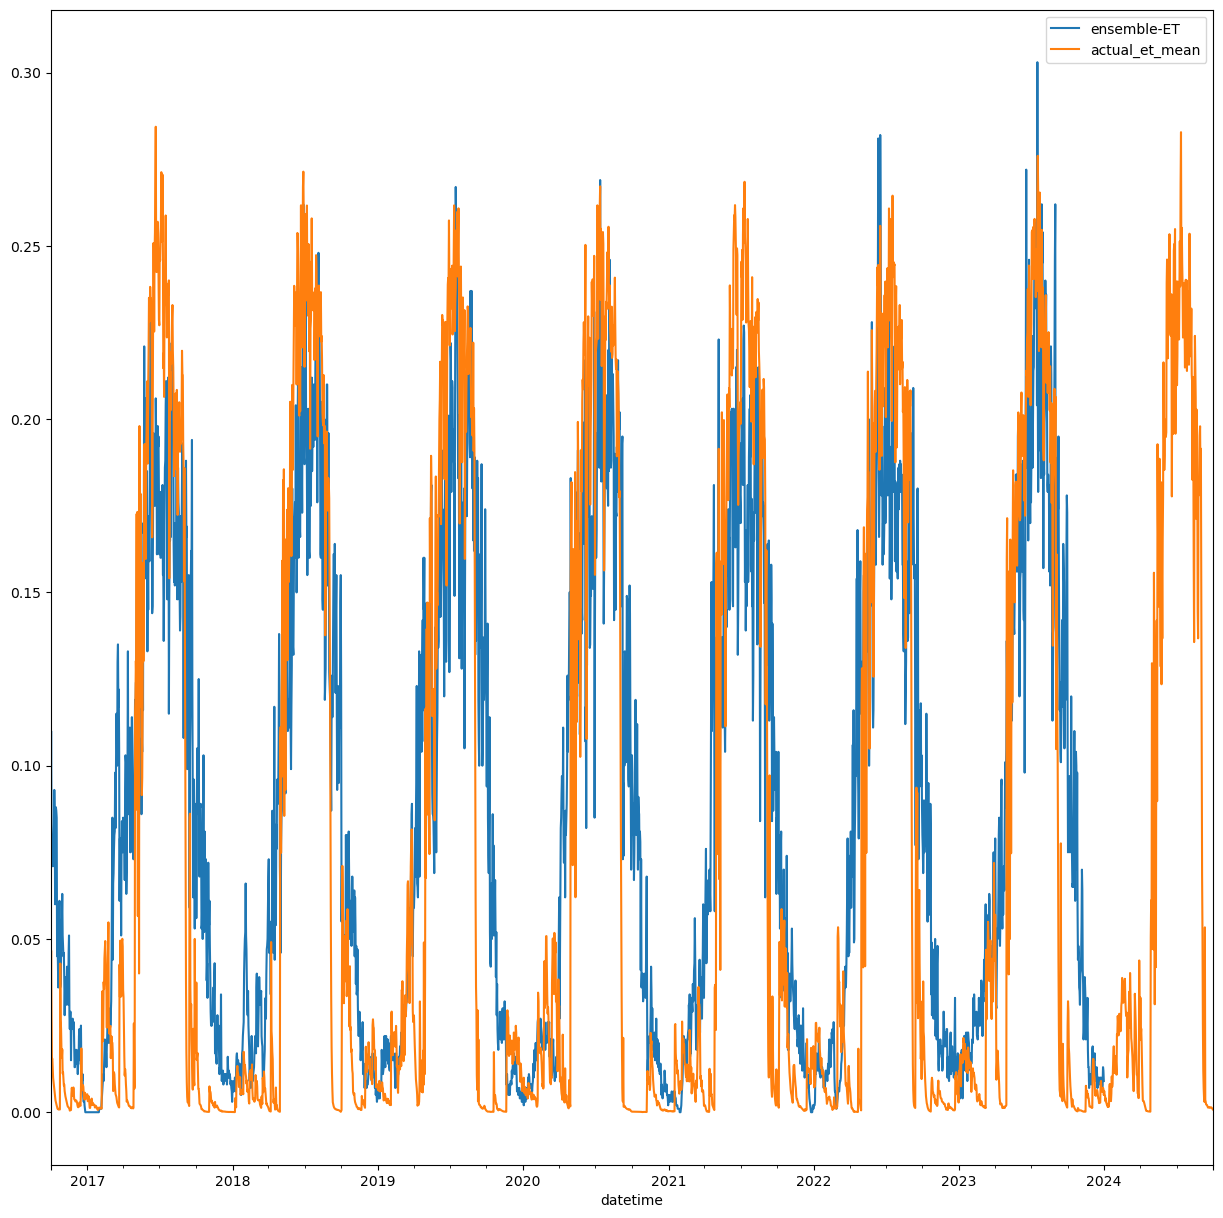

In [39]:
all_data.loc['BC1'][['ensemble-ET','actual_et_mean']].loc[pd.to_datetime('2016-10-01'):pd.to_datetime('2024-10-01')].plot()

# Comparison

In [40]:
import numpy as np
from scipy import signal, stats

def pairwise_valid(a, b):
    mask = np.isfinite(a) & np.isfinite(b)
    return a[mask], b[mask]

def rmse(a, b):
    a, b = pairwise_valid(a, b)
    return np.sqrt(np.mean((a - b)**2))

def mae(a, b):
    a, b = pairwise_valid(a, b)
    return np.mean(np.abs(a - b))

def pearson_r(a, b):
    a, b = pairwise_valid(a, b)
    return np.corrcoef(a, b)[0,1]

def spearman_r(a, b):
    a, b = pairwise_valid(a, b)
    return stats.spearmanr(a, b, nan_policy='omit').correlation

def nse(obs, sim):
    o, s = pairwise_valid(obs, sim)
    return 1 - np.sum((o - s)**2)/np.sum((o - np.mean(o))**2)

def kge(obs, sim):
    o, s = pairwise_valid(obs, sim)
    r = np.corrcoef(o, s)[0,1]
    beta = np.mean(s)/np.mean(o)
    gamma = (np.std(s, ddof=1)/np.mean(s)) / (np.std(o, ddof=1)/np.mean(o))
    return 1 - np.sqrt((r-1)**2 + (beta-1)**2 + (gamma-1)**2)

def best_lag_corr(a, b, max_lag):
    """Return (lag_in_samples, correlation_at_that_lag). Positive lag => b lags a."""
    a, b = pairwise_valid(a, b)
    lags = np.arange(-max_lag, max_lag+1)
    corrs = [np.corrcoef(a[max(0,lag):len(a)+min(0,lag)],
                         b[max(0,-lag):len(b)+min(0,-lag)])[0,1] for lag in lags]
    i = int(np.nanargmax(corrs))
    return lags[i], corrs[i]

def dtw_distance(x, y, window=None):
    """Simple DTW (O(n^2)); optionally constrain warping with a Sakoe–Chiba window."""
    n, m = len(x), len(y)
    D = np.full((n+1, m+1), np.inf)
    D[0,0] = 0.0
    for i in range(1, n+1):
        j_min = 1 if window is None else max(1, i-window)
        j_max = m if window is None else min(m, i+window)
        for j in range(j_min, j_max+1):
            cost = (x[i-1]-y[j-1])**2
            D[i,j] = cost + min(D[i-1,j], D[i,j-1], D[i-1,j-1])
    return np.sqrt(D[n,m])


In [41]:

# --- 4) Driver: build comparison matrices ----------------------------------------

def compare_series(df, columns, z_for_shape=True, save_csv=False, out_dir=None):
    """Compute pairwise comparison matrices for selected columns in df.

    Parameters
    ----------
    df : pandas.DataFrame
        Daily time series with a DatetimeIndex; columns are ET estimates.
    columns : list[str]
        Subset of df columns to compare.
    z_for_shape : bool, default True
        If True, compute Pearson/Spearman/DTW on z-scored versions (shape-focused).
    save_csv : bool, default False
        If True, saves each matrix as CSV in out_dir.
    out_dir : str or Path, optional
        Destination directory for CSVs if save_csv is True.

    Returns
    -------
    dict[str, pandas.DataFrame]
        A dictionary of matrices keyed by metric names.
    """
    df = df.copy()
    df = df.sort_index()
    # Ensure daily frequency (doesn't fill gaps; assumes input is already daily or nearly so)
    # If you want strict daily alignment with interpolation, do it explicitly before calling.

    cols = [c for c in columns if c in df.columns]
    if len(cols) < 2:
        raise ValueError("Need at least two valid columns to compare.")
    X = df[cols]

    # Z-score version for shape metrics if requested
    if z_for_shape:
        Xz = (X - X.mean()) / X.std(ddof=1)
    else:
        Xz = X.copy()

    n = len(cols)
    idx = pd.Index(cols, name="series")

    # Initialize matrices
    RMSE   = pd.DataFrame(np.nan, index=idx, columns=idx)
    MAE    = pd.DataFrame(np.nan, index=idx, columns=idx)
    PEAR   = pd.DataFrame(np.nan, index=idx, columns=idx)  # Pearson r
    SPEAR  = pd.DataFrame(np.nan, index=idx, columns=idx)  # Spearman rho
    NSEm   = pd.DataFrame(np.nan, index=idx, columns=idx)
    KGEm   = pd.DataFrame(np.nan, index=idx, columns=idx)
    #LAG    = pd.DataFrame(np.nan, index=idx, columns=idx)  # best lag (days), sign: col_j lags col_i if +lag
    #R_AT_LAG = pd.DataFrame(np.nan, index=idx, columns=idx)  # max correlation at that lag
    #DTWm   = pd.DataFrame(np.nan, index=idx, columns=idx)  # DTW on z-scored series if z_for_shape

    # Compute pairwise
    for i, ci in enumerate(cols):
        for j, cj in enumerate(cols):
            if j < i:
                # fill symmetry from previously computed value where applicable
                RMSE.loc[ci, cj] = RMSE.loc[cj, ci]
                MAE.loc[ci, cj]  = MAE.loc[cj, ci]
                PEAR.loc[ci, cj] = PEAR.loc[cj, ci]
                SPEAR.loc[ci, cj]= SPEAR.loc[cj, ci]
                NSEm.loc[ci, cj] = NSEm.loc[cj, ci]
                KGEm.loc[ci, cj] = KGEm.loc[cj, ci]
                # DTWm.loc[ci, cj] = DTWm.loc[cj, ci]
                # Asymmetric metrics (lag) are not symmetric; compute both directions
                continue

            xi = X[ci].to_numpy()
            xj = X[cj].to_numpy()
            xi_z = Xz[ci].to_numpy()
            xj_z = Xz[cj].to_numpy()

            # Units-based (raw)
            RMSE.loc[ci, cj] = rmse(xi, xj)
            MAE.loc[ci, cj]  = mae(xi, xj)
            NSEm.loc[ci, cj] = nse(xi, xj)     # treat ci as "obs", cj as "sim"
            KGEm.loc[ci, cj] = kge(xi, xj)     # same convention

            # Shape-based (z if requested)
            PEAR.loc[ci, cj]  = pearson_r(xi_z, xj_z)
            SPEAR.loc[ci, cj] = spearman_r(xi_z, xj_z)

            # Best lag & correlation (computed on z-scored for stability)
            #lag, rmax = best_lag_corr(xi_z, xj_z, max_lag=max_lag)
            #LAG.loc[ci, cj] = lag
            #R_AT_LAG.loc[ci, cj] = rmax

            # DTW (z-scored)
            #DTWm.loc[ci, cj] = dtw_distance(xi_z, xj_z, window=dtw_window)

    # Mirror symmetric parts
    RMSE = RMSE.combine_first(RMSE.T)
    MAE  = MAE.combine_first(MAE.T)
    PEAR = PEAR.combine_first(PEAR.T)
    SPEAR= SPEAR.combine_first(SPEAR.T)
    NSEm = NSEm.combine_first(NSEm.T)
    KGEm = KGEm.combine_first(KGEm.T)
    #DTWm = DTWm.combine_first(DTWm.T)

    matrices = {
        "RMSE": RMSE, 
        "MAE": MAE, 
        "Pearson_r(z)": PEAR, 
        "Spearman_rho(z)": SPEAR,
        "NSE(ci as obs, cj as sim)": NSEm,
        "KGE(ci as obs, cj as sim)": KGEm,

    }

    if save_csv:
        import os
        out_dir = os.fspath(out_dir or ".")
        os.makedirs(out_dir, exist_ok=True)
        for name, M in matrices.items():
            M.to_csv(os.path.join(out_dir, f"{name.replace(' ', '_').replace('/', '_')}.csv"))

    return matrices


In [42]:
all_data.index.get_level_values(0).unique()

Index(['BC1', 'BC10', 'BC11', 'BC12', 'BC20', 'BC22', 'BC29', 'BC45', 'CW1',
       'CW25',
       ...
       'BC13', 'UM3.1', 'UM42', 'LM33', 'BC14', ' CW5', 'CW7', 'CW1B', 'CW30',
       'LM7'],
      dtype='object', name='Meterno', length=185)

In [43]:
et_cols = ['etDis','etEns','etPTJ','etSSE','eteeM','eeMetricET','actual_et_mean']
matrices = {}
for ind in all_data.index.get_level_values(0).unique():
    print(ind)
    matrices[ind] = pd.concat(compare_series(all_data.loc[ind], et_cols, z_for_shape=True))

BC1
BC10
BC11
BC12
BC20
BC22
BC29
BC45
CW1
CW25
LM20
LM22
LM27
MD43
MD49
UM24
UM3
UM56
BC17
BC19
BC2
BC21
BC23
BC24
BC25
BC26
BC28
BC30
BC31
BC32
BC33
BC34
BC35
BC36
BC4
BC42
BC46
BC5
BC6
BC7
BC8
BC9
CW10
CW11
CW13
CW14
CW16
CW19
CW2
CW21
CW24
CW26
CW27
CW28
CW29
CW31
CW32
CW33
CW35
CW36
CW38
CW39
CW4
CW40
CW41
CW42
CW43
CW44
CW45
CW46
CW47
CW48
CW49
CW5
CW51
CW52
CW53
CW54
CW55
CW58
CW59
CW6
CW60
CW61
CW62
CW63
CW65
CW66
CW67
CW68
CW71
CW72
CW8
LM10
LM13
LM14
LM15
LM16
LM18
LM19
LM21
LM24
LM25
LM28
LM29
LM3
LM31
LM32
LM35
LM36
LM37
LM38
LM4
LM40
LM42
LM48
LM5
LM50
LM51
LM52
LM53
LM6
LM71
LM8
LM9
MD44
MD45
MD47
MD54
MD56
MD57
MD58
MD60
MD61
MD62
MD65
MD66
PJC1
PJC2
PJC4
PJC5
PJC6
PJC7
PJC8
UM1
UM10
UM11
UM14
UM15
UM19
UM2
UM21
UM22
UM23
UM25
UM26
UM30
UM31
UM32
UM34
UM36
UM37
UM38
UM39
UM4
UM40
UM41
UM48
UM5
UM50
UM53
UM55
UM6&9
UM7
UM8
BC13
UM3.1
UM42
LM33
BC14
 CW5
CW7
CW1B
CW30
LM7


In [46]:
comparison_matrices = pd.concat(matrices).dropna(how='all')
comparison_matrices.index.names = ['Meterno','Metric','series']
comparison_matrices = comparison_matrices.reset_index().set_index(['Metric','Meterno'])

In [47]:
pearson = comparison_matrices.loc["Pearson_r(z)"]
pearson = pearson[pearson['series'].isin(['etDis','etEns','etPTJ','etSSE','eteeM'])]
pearson.sort_values('actual_et_mean', ascending=False)

series,series,etDis,etEns,etPTJ,etSSE,eteeM,eeMetricET,actual_et_mean
Meterno,,,,,,,,
BC1,etEns,0.943485,1.000000,0.960023,0.974935,0.965323,0.986058,0.843730
BC1,etSSE,0.894583,0.974935,0.914269,1.000000,0.969842,0.985462,0.835422
BC10,etEns,0.937660,1.000000,0.956077,0.968768,0.970673,0.960798,0.818040
BC1,eteeM,0.870814,0.965323,0.905247,0.969842,1.000000,0.990262,0.817144
LM27,etSSE,0.878103,0.962876,0.900493,1.000000,0.957213,0.966261,0.810266
BC1,etPTJ,0.922960,0.960023,1.000000,0.914269,0.905247,0.953897,0.806236
LM27,etEns,0.935479,1.000000,0.959412,0.962876,0.952075,0.970702,0.801825
BC10,etSSE,0.898417,0.968768,0.894631,1.000000,0.958576,0.954129,0.799820
BC10,eteeM,0.880516,0.970673,0.911490,0.958576,1.000000,0.973404,0.795883


In [140]:
pearson.sort_values('actual_et_mean', ascending=True)

series,series,etDis,etEns,etPTJ,etSSE,eteeM,actual_et_mean
Meterno,,,,,,,
LM20,etDis,1.000000,0.902817,0.859205,0.822749,0.794491,0.668962
LM20,eteeM,0.794491,0.947217,0.895429,0.959653,1.000000,0.692379
LM20,etPTJ,0.859205,0.950378,1.000000,0.891176,0.895429,0.715631
LM22,eteeM,0.844834,0.954585,0.897906,0.961181,1.000000,0.723252
LM22,etDis,1.000000,0.938920,0.908866,0.878610,0.844834,0.725958
LM20,etSSE,0.822749,0.957983,0.891176,1.000000,0.959653,0.732580
LM27,etDis,1.000000,0.935479,0.899560,0.878103,0.843429,0.736071
BC10,etDis,1.000000,0.937660,0.904168,0.898417,0.880516,0.741086
LM22,etPTJ,0.908866,0.957678,1.000000,0.900116,0.897906,0.745250


In [11]:
len(dlyflow.index.get_level_values(0).unique())

54